In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
import pandas as pd 
#в случае старой версии пандас может не работать метод json_normalize. Я использовал версию 1.0.4. 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html
import time
import random
from tqdm import tqdm
import time

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
#Техническая функция
def to_double(s):
    return float(s)

#Эта функция подключается к апи и получает данные по стоимости индексов, принимая на вход тикер.
#Использование Пандас (2 балла. Посложнее будет в части 2) и Апи, которого не было в дз (2 балла)
def getDfValues(symbol):
    url = "https://www.alphavantage.co/query?"
    params = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED",
        "symbol":symbol,
        "interval":"5min",
        "apikey":"L684S05FNIPDNCPE"
    }
    g = requests.get(url, params=params)
    q = g.json()
    df = pd.json_normalize(q)
    df_t = df.transpose(copy = True)
    res = []
    for line in df_t.index:
        if line[-5:] == "close" and line[-7:] != "d close":
            res.append(line)
    df_1 = df_t[0].loc[res]
    df_1.index = [line[-19:-9] for line in df_1.index]
    df_2 = pd.DataFrame(df_1)
    df_2['Value'] = df_2[0].apply(to_double)
    del df_2[0]
    return df_2.sort_index()

In [26]:
import requests
from bs4 import BeautifulSoup
#С помощью веб скреппинга (1 балл) получаем данные о существующих тикерах

In [27]:
url = "https://www.masterforex-v.org/wiki/ticker-symbol.html"
r = requests.get(url)
r.ok

True

In [9]:
soup = BeautifulSoup(r.text, 'lxml')

In [10]:
mt = soup.find_all("div", {"id" : "mainsite"})[0].find_all("table", {'class' : 'mainsite'})[0]

In [11]:
bk = mt.tr.find_all("td", {"class" : 'site-center'})[0].section.article.find_all("div", {"class" : 'book-content'})[0]

In [12]:
nt = bk.find_all("ul")

In [13]:
#Соберем достаточное количество тикеров
tickers = []

for tag in nt[2].find_all("li"):
    tickers.append(tag.strong.text.strip())
for tag in nt[4].find_all("li"):
    tickers.append(tag.strong.text.strip())
for tag in nt[5].find_all("li"):
    tickers.append(tag.strong.text[:-2].strip())
for tag in nt[3].find_all("li"):
    tickers.append(tag.strong.text.strip())

In [14]:
#Собираем таблички с данными и использование tqdm (1 балл). Это работает очень долго
compl = [False] * len(tickers)
tables = [pd.DataFrame()] * len(tickers)
try_ = 0
pbar = tqdm(total=100)
for try_ in range(10):
    pbar.update(10)
    for i in range(len(tickers)):
        if not compl[i]:
            df = getDfValues(tickers[i])
            if df.shape[0] > 0:
                tables[i] = df
                compl[i] = True

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.55s/it]

In [15]:
#Теперь выгрузим все полученные таблицы в csv (можно не запускать, для работы следующих частей это не важно)
file = open('tickers', 'w')
for i in range(len(tables)):
    if (compl[i]):
        tables[i].to_csv(tickers[i] + '.csv')
        file.write(tickers[i] + '\n')
file.close()

In [16]:
#Создаем базу данных и кладем в нее наши таблицы (1 балл)
from sqlite3 import connect

In [17]:
conn = connect("my_database.sqlite")

for i in range(len(tables)):
    tables[i].to_sql(tickers[i], conn, if_exists="replace")
c = conn.cursor()

In [18]:
#Реализуем простейшие методы, чтобы доставать данные и строить графики
def get_df(ticker):
    st = "select * from " + ticker
    return pd.read_sql(
    st, conn)

get_df("MMM")

,index,Value
0,2000-07-31,90.06
1,2000-08-31,93.02
2,2000-09-29,91.13
3,2000-10-31,96.63
4,2000-11-30,99.88
...,...,...
235,2020-02-28,149.24
236,2020-03-31,136.51
237,2020-04-30,151.92
238,2020-05-29,156.44


In [19]:
def plot_df(ticker):
    get_df(ticker).plot()

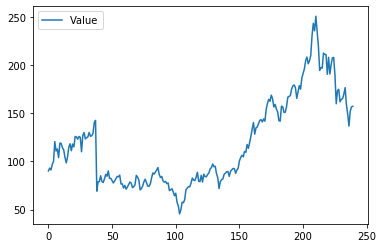

In [20]:
plot_df("MMM")

MMM


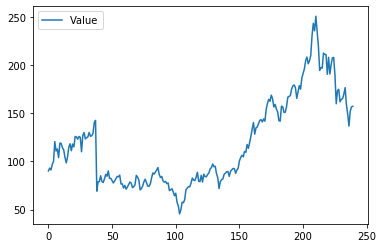

In [21]:
#Позволяет построить график по тикеру
st = input()
if st in tickers:
    plot_df(st)
else:
    print("There no suck ticker")

In [22]:
#Позволяет получить данные по тикеру
st = input()
if st in tickers:
    print(get_df(st))
else:
    print("There no suck ticker")

MMM
          index   Value
0    2000-07-31   90.06
1    2000-08-31   93.02
2    2000-09-29   91.13
3    2000-10-31   96.63
4    2000-11-30   99.88
..          ...     ...
235  2020-02-28  149.24
236  2020-03-31  136.51
237  2020-04-30  151.92
238  2020-05-29  156.44
239  2020-06-15  157.05

[240 rows x 2 columns]
